In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

def power(a: int, b: int) -> int:
    """Calculate a raised to the power of b.

    Args:
        a: base integer
        b: exponent integer
    """
    return a ** b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([power])

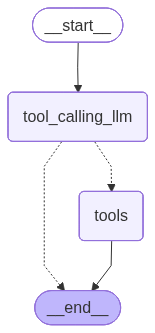

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([power]))  # use power tool instead of multiply
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message from assistant is a tool call -> tools_condition routes to tools
    # Otherwise -> END
    tools_condition,
)
builder.add_edge("tools", END)

# Compile and visualize graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 4 raised to power of 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 4 raised to power of 2?
================================== Ai Message ==================================
Tool Calls:
  power (call_GMWKzQm3GkT543WGc9D2iQ1v)
 Call ID: call_GMWKzQm3GkT543WGc9D2iQ1v
  Args:
    a: 4
    b: 2
================================= Tool Message =================================
Name: power

16


In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello world
================================== Ai Message ==================================

Hello! How can I assist you today?


# screenshots from langgraph studio

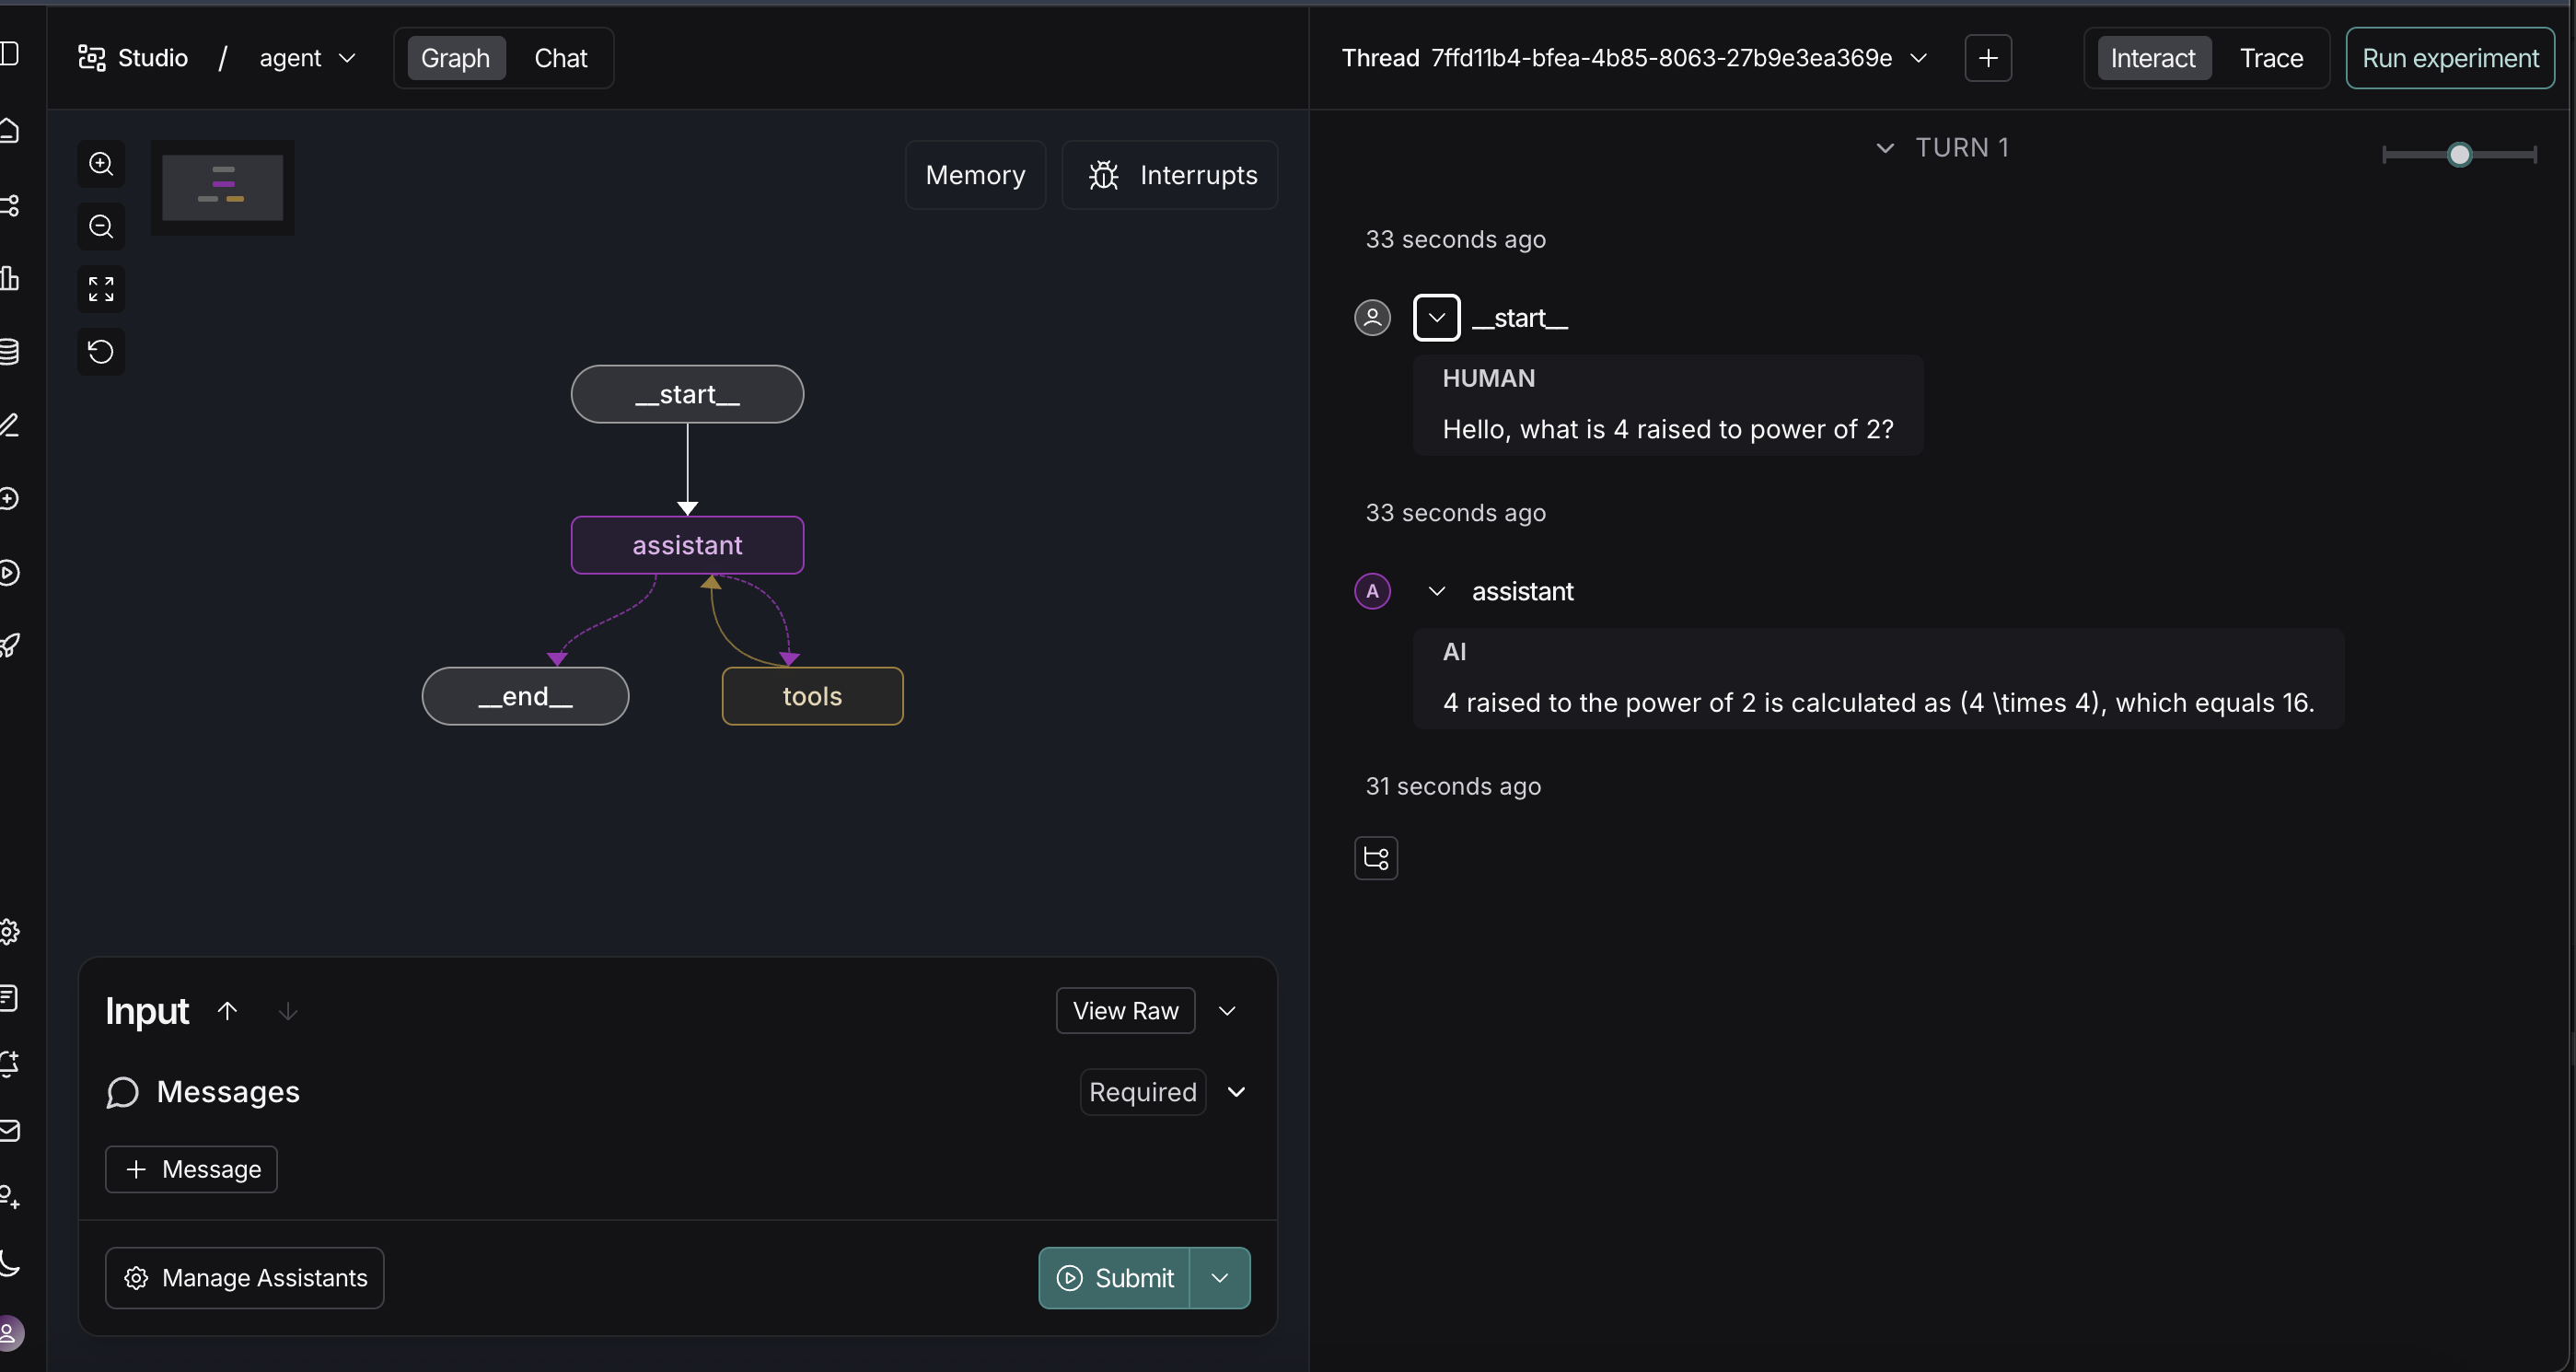
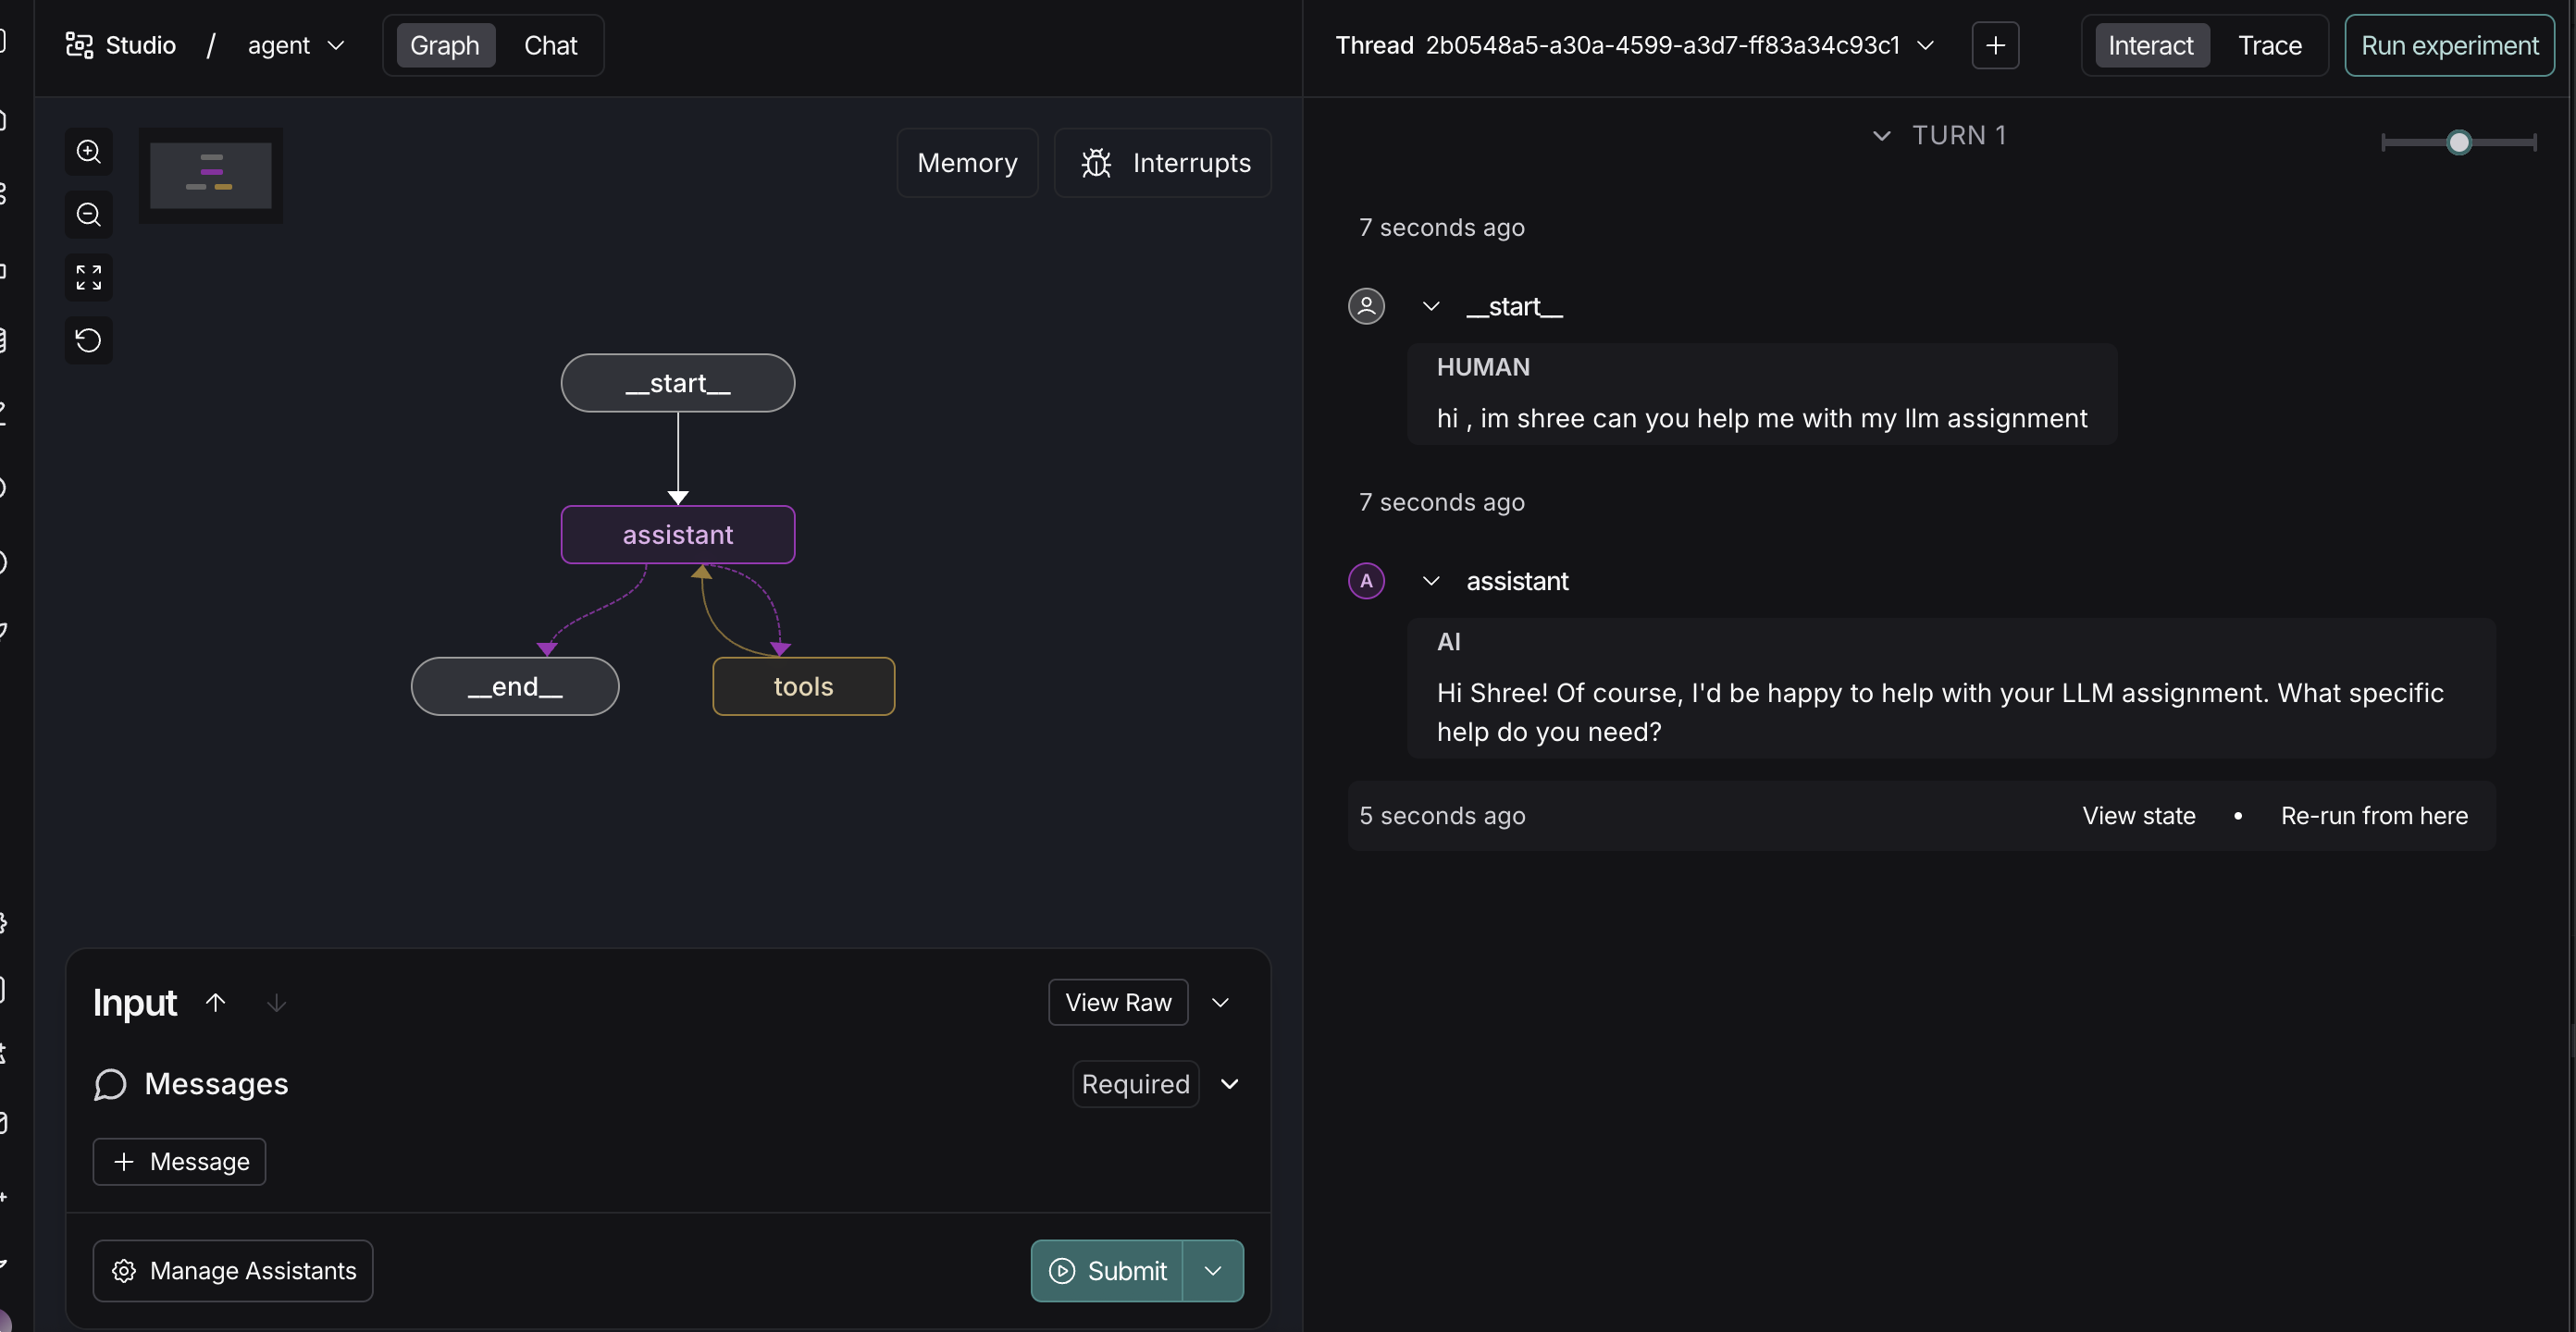